In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Configuration values for common items such as figures and/or graphs plots/subplots
fig_height = 10.0
fig_width = 10.0

transactions_df = pd.read_excel("./Stocks_Sample.xlsx",
                              sheet_name="Stocks",
                              usecols="C:M",
                              skiprows=[0,1,2])

# Merge the Counter Name and Code into a single column
transactions_df["Counter Name"] = transactions_df["Counter Name"] + " (" + transactions_df["Code"] + ")"
transactions_df.drop(columns="Code",inplace=True)

transactions_df["Counter Name"] = transactions_df["Counter Name"].astype(str)
#print(transactions_df.columns)

# Cleanup - Drop empty data columns and rows

stocks_df = transactions_df.filter(items = ["Counter Name","Type","Transaction","Quantity","Total"], axis = "columns").groupby(["Counter Name","Type","Transaction"]).sum()
#print(stocks_df)

[INFO] Missing Sell Transaction for Singtel (Z74). Adding default entry
[INFO] Missing Sell Transaction for Singtel (Z74). Adding default entry
[INFO] Missing Sell Transaction for Ezra Holdings Limited (5DN). Adding default entry
[INFO] Missing Sell Transaction for Ezra Holdings Limited (5DN). Adding default entry
[INFO] Missing Sell Transaction for Ezra Holdings Limited (5DN). Adding default entry
[INFO] Missing Sell Transaction for Singapore Exchange (S68). Adding default entry
[INFO] Missing Sell Transaction for Singapore Exchange (S68). Adding default entry
[INFO] Missing Sell Transaction for Singapore Airlines (SIA) (C6L). Adding default entry
[INFO] Missing Sell Transaction for Singapore Airlines (SIA) (C6L). Adding default entry
[INFO] Missing Sell Transaction for Singtel (Z74). Adding default entry
[INFO] Missing Sell Transaction for Singtel (Z74). Adding default entry
[INFO] Missing Sell Transaction for Singapore Exchange (S68). Adding default entry
[INFO] Missing Sell Transac

/var/folders/84/36p3jlc97hb5xm4d65_ffysr0000gn/T/ipykernel_30446/2299022519.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"[INFO] Missing Sell Transaction for {stock_counter[0]}. Adding default entry")
/var/folders/84/36p3jlc97hb5xm4d65_ffysr0000gn/T/ipykernel_30446/2299022519.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"[INFO] Missing Sell Transaction for {stock_counter[0]}. Adding default entry")
/var/folders/84/36p3jlc97hb5xm4d65_ffysr0000gn/T/ipykernel_30446/2299022519.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys

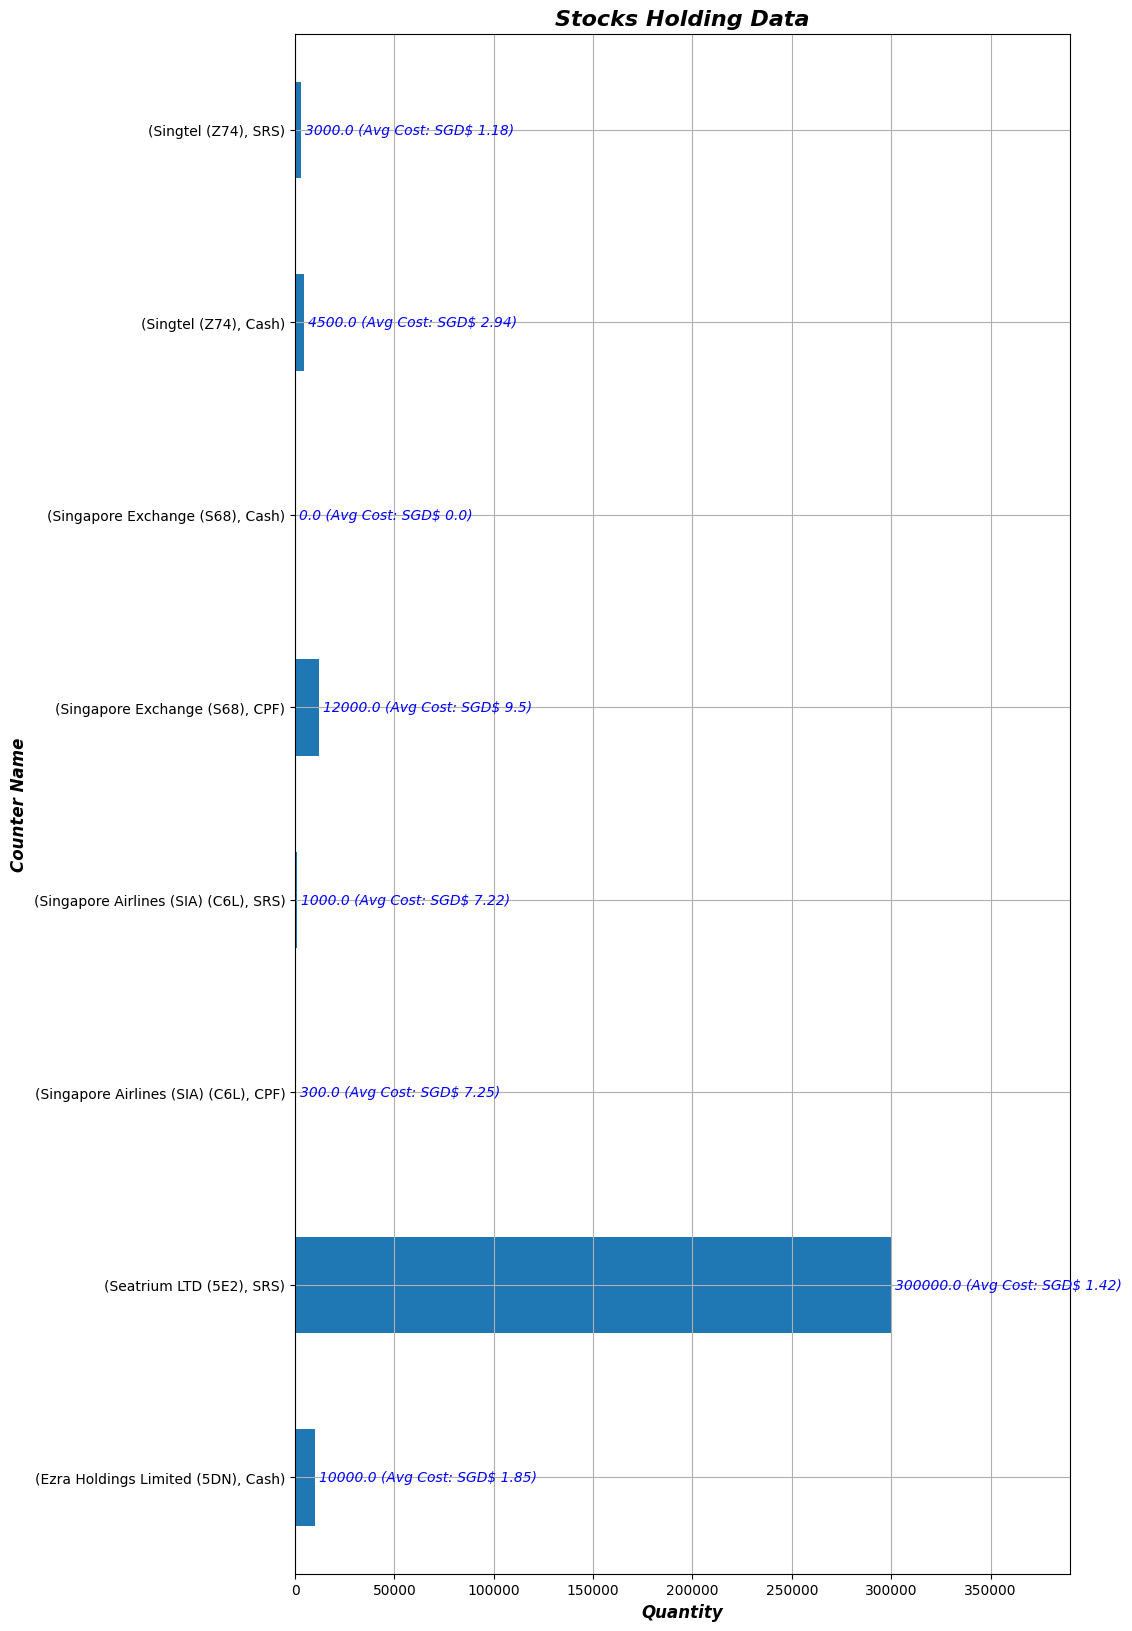

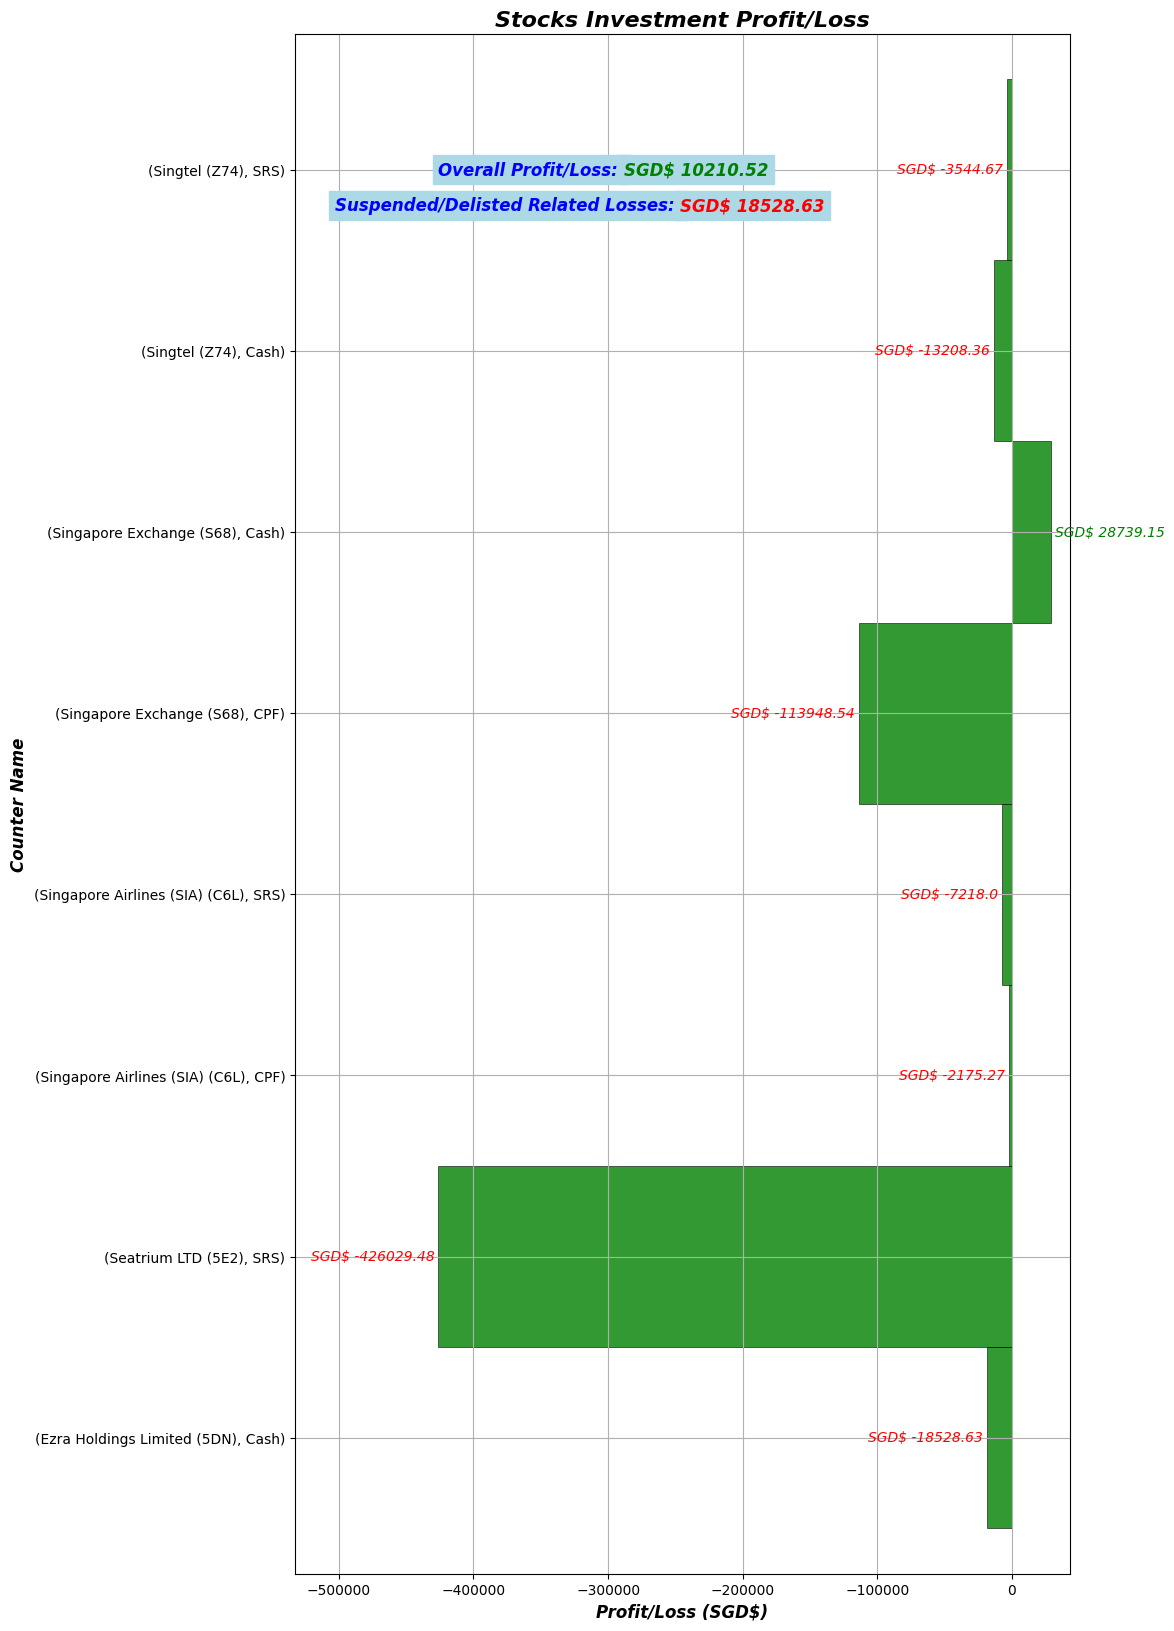

In [2]:
stock_list = transactions_df[["Counter Name","Type"]].drop_duplicates()

# Fill in missing entries to assist in subsequent processing
for idx,stock_counter in stock_list.iterrows():
   if not stocks_df.index.isin([(stock_counter["Counter Name"], 
                                 stock_counter["Type"],"Buy")]).any() :
        print(f"[INFO] Missing Sell Transaction for {stock_counter[0]}. Adding default entry")
        stocks_df.loc[(stock_counter["Counter Name"],stock_counter["Type"],"Buy"),:] = (0.0,0.0)   

   if not stocks_df.index.isin([(stock_counter["Counter Name"], 
                                 stock_counter["Type"],"Sell")]).any() :
        print(f"[INFO] Missing Sell Transaction for {stock_counter[0]}. Adding default entry")
        stocks_df.loc[(stock_counter["Counter Name"],stock_counter["Type"],"Sell"),:] = (0.0,0.0)

   if not stocks_df.index.isin([(stock_counter["Counter Name"], 
                                 stock_counter["Type"],"Other")]).any() :
        print(f"[INFO] Missing Sell Transaction for {stock_counter[0]}. Adding default entry")
        stocks_df.loc[(stock_counter["Counter Name"],stock_counter["Type"],"Other"),:] = (0.0,0.0)

   if not stocks_df.index.isin([(stock_counter["Counter Name"], 
                                 stock_counter["Type"],"Dividend")]).any() :
        print(f"[INFO] Missing Sell Transaction for {stock_counter[0]}. Adding default entry")
        stocks_df.loc[(stock_counter["Counter Name"],stock_counter["Type"],"Dividend"),:] = (0.0,0.0)

stocks_df.sort_values(by=["Counter Name","Type","Transaction"],inplace=True)

#print(stocks_df)

stocks_buy = stocks_df[np.isin(stocks_df.index.get_level_values(2),"Buy")]
stocks_buy.reset_index(level=2,drop=True,inplace = True)

stocks_sell = stocks_df[np.isin(stocks_df.index.get_level_values(2),"Sell")]
stocks_sell.reset_index(level=2,drop=True,inplace = True)

stocks_other = stocks_df[np.isin(stocks_df.index.get_level_values(2),"Other")]
stocks_other.reset_index(level=2,drop=True,inplace = True)

stocks_dividend = stocks_df[np.isin(stocks_df.index.get_level_values(2),"Dividend")]
stocks_dividend.reset_index(level=2,drop=True,inplace = True)

stocks_pnl = stocks_sell - stocks_buy + stocks_other + stocks_dividend
# Correct the quantity column to ensure positive values due to previous math operation.
stocks_pnl["Quantity"] = stocks_pnl["Quantity"].abs()

stocks_pnl.insert(1,"Purchase Price",stocks_buy["Total"].values,True)
stocks_pnl.insert(2,"Sold Price",stocks_sell["Total"].values,True)
stocks_pnl.rename(columns={"Total":"Profit/Loss (SGD)"},inplace=True)

#print(stocks_pnl)

ax = stocks_pnl["Quantity"].plot(kind="barh",legend = False,grid=True,figsize=(fig_width,fig_height*2),lw=0.5)
stock_avg_cost = np.round(np.abs( (stocks_pnl["Profit/Loss (SGD)"]/stocks_pnl["Quantity"]).replace(to_replace=math.inf,value=0.00) )   ,2)

bar_labels = stocks_pnl["Quantity"].astype(str) + " (Avg Cost: SGD$ " + stock_avg_cost.astype(str)  + ")"

ax.bar_label(ax.containers[0],labels=bar_labels,padding=3,fontstyle="italic",fontweight="normal",color="b")
ax.set_title("Stocks Holding Data",fontsize=16, fontweight="extra bold", fontstyle="italic")
ax.set_xlabel("Quantity",fontsize=12, fontweight="extra bold", fontstyle="italic")
ax.set_ylabel("Counter Name",fontsize=12, fontweight="extra bold", fontstyle="italic")

# Adjust to allow the labels to be seen proper in the plotted graph
ax.set_xlim(right = (stocks_pnl["Quantity"].max() *1.3))

plt.show()

ax = stocks_pnl["Profit/Loss (SGD)"].plot(kind="barh",legend = False,grid=True,figsize=(fig_width,fig_height*2),
                                          edgecolor="black", width=1,alpha=0.8,lw=0.5, color="g")
bar_labels = "SGD$ " + np.round(stocks_pnl["Profit/Loss (SGD)"],2).astype(str)
bar_annotations = ax.bar_label(ax.containers[0],labels=bar_labels,padding=3,fontstyle="italic",fontweight="normal",color="b")

# Color the bar label text based on profit (i.e. > 0) or loss (i.e. < 0)
for bar_annotation in bar_annotations:
        label_value = np.float64 (bar_annotation.get_text().split()[1])
        if label_value < 0:
             bar_annotation.set_color("r")
        elif label_value == 0:
                bar_annotation.set_color("b") 
        else:
             bar_annotation.set_color("g")

ax.set_title("Stocks Investment Profit/Loss",fontsize=16, fontweight="extra bold", fontstyle="italic")
ax.set_xlabel("Profit/Loss (SGD$)",fontsize=12, fontweight="extra bold", fontstyle="italic")
ax.set_ylabel("Counter Name",fontsize=12, fontweight="extra bold", fontstyle="italic")

# Adjust to allow the labels to be seen proper in the plotted graph
ax.set_xlim(left = (stocks_pnl["Profit/Loss (SGD)"].min()*1.25), right = (stocks_pnl["Profit/Loss (SGD)"].max()*1.5))

# Calculate overall Profit/Loss for stocks with no holdings
# Find delisted and suspended counters as those are considered total loss
permaloss_list = (transactions_df[(transactions_df["Counter Status"] == "Suspended") | (transactions_df["Counter Status"] == "Delisted")])
permaloss = 0.0

for idx,permaloss_stock in permaloss_list.iterrows() :
     permaloss += (stocks_pnl.loc[(permaloss_stock["Counter Name"],permaloss_stock["Type"])])["Profit/Loss (SGD)"]

overall_pnl = stocks_pnl.query("Quantity == 0.0")["Profit/Loss (SGD)"].sum() + permaloss

# Create overall profit/loss text label to be put on the plot.
overall_pnl_text_common_format = {"fontstyle":"italic", 
                                  "weight":"bold",
                                  "fontsize":12,
                                  "alpha":1,
                                  "horizontalalignment":"left",
                                  "verticalalignment":"center",
                                  "backgroundcolor":"lightblue"}

# Location of the text is based on the plot's coordinate system
overall_pnl_text_x = stocks_pnl["Profit/Loss (SGD)"].min()
overall_pnl_text_y = stocks_pnl.shape[0] - 1

overall_pnl_text = ax.text(overall_pnl_text_x,overall_pnl_text_y,f"Overall Profit/Loss: ",overall_pnl_text_common_format,color="b")

if overall_pnl >= 0 :
     overall_pnl_text = ax.annotate(f"SGD$ {np.around(overall_pnl,2)}", 
                                    xycoords=overall_pnl_text, 
                                    xy=(1, 0.5), 
                                    color="g", 
                                    fontstyle=overall_pnl_text_common_format["fontstyle"],
                                    weight=overall_pnl_text_common_format["weight"],
                                    fontsize=overall_pnl_text_common_format["fontsize"],
                                    alpha = overall_pnl_text_common_format["alpha"],
                                    horizontalalignment=overall_pnl_text_common_format["horizontalalignment"],
                                    verticalalignment=overall_pnl_text_common_format["verticalalignment"],
                                    backgroundcolor=overall_pnl_text_common_format["backgroundcolor"])
else :
     overall_pnl_text = ax.annotate(f"SGD$ {np.around(overall_pnl,2)}", 
                                    xycoords=overall_pnl_text, 
                                    xy=(1, 0.5), 
                                    color="r",                                     
                                    fontstyle=overall_pnl_text_common_format["fontstyle"],
                                    weight=overall_pnl_text_common_format["weight"],
                                    fontsize=overall_pnl_text_common_format["fontsize"],
                                    alpha = overall_pnl_text_common_format["alpha"],
                                    horizontalalignment=overall_pnl_text_common_format["horizontalalignment"],
                                    verticalalignment=overall_pnl_text_common_format["verticalalignment"],
                                    backgroundcolor=overall_pnl_text_common_format["backgroundcolor"])

overall_pnl_text = ax.annotate(f"Suspended/Delisted Related Losses: ", 
                               xycoords=overall_pnl_text, 
                               xy=(-2, -1.5),
                               color="b",
                               fontstyle=overall_pnl_text_common_format["fontstyle"],
                               weight=overall_pnl_text_common_format["weight"],
                               fontsize=overall_pnl_text_common_format["fontsize"],
                               alpha = overall_pnl_text_common_format["alpha"],
                               horizontalalignment=overall_pnl_text_common_format["horizontalalignment"],
                               verticalalignment=overall_pnl_text_common_format["verticalalignment"],
                               backgroundcolor=overall_pnl_text_common_format["backgroundcolor"])

overall_pnl_text = ax.annotate(f"SGD$ {np.abs(permaloss)}", 
                               xycoords=overall_pnl_text, 
                               xy=(1, 0.5),
                               color="r",
                               fontstyle=overall_pnl_text_common_format["fontstyle"],
                               weight=overall_pnl_text_common_format["weight"],
                               fontsize=overall_pnl_text_common_format["fontsize"],
                               alpha = overall_pnl_text_common_format["alpha"],
                               horizontalalignment=overall_pnl_text_common_format["horizontalalignment"],
                               verticalalignment=overall_pnl_text_common_format["verticalalignment"],
                               backgroundcolor=overall_pnl_text_common_format["backgroundcolor"])

plt.show()

